In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report
import pathlib

In [2]:
dataset_path = "D:\Deep Learning project\dataset"
dataset_dir = pathlib.Path(dataset_path)

In [3]:
class_names = [item.name for item in dataset_dir.iterdir() if item.is_dir()]

print(class_names)

['algal leaf', 'bird eye spot', 'brown blight', 'gray light', 'healthy', 'red leaf spot', 'white spot']


In [4]:
for class_i in class_names:
    image_count = len(list(dataset_dir.glob(f'{class_i}/*.jpg')))
    print(f"Images in class {class_i}:",image_count)

Images in class algal leaf: 113
Images in class bird eye spot: 100
Images in class brown blight: 113
Images in class gray light: 100
Images in class healthy: 74
Images in class red leaf spot: 143
Images in class white spot: 142


In [5]:
# Parameter setting
train_batch = 128
val_batch = 128
img_height = 224
img_width = 224
IMG_SIZE = (img_height, img_width)
val_split = 0.2

In [6]:
# Loading data for Training
train_ds = tf.keras.utils.image_dataset_from_directory(dataset_dir,
                                                       validation_split=val_split,
                                                       subset="training",
                                                       seed=123,
                                                       image_size=(img_height, img_width),
                                                       batch_size=train_batch
                                                      )

Found 785 files belonging to 7 classes.
Using 628 files for training.


In [7]:
# Loading data for Validation
val_ds = tf.keras.utils.image_dataset_from_directory(dataset_dir,                                                            
                                                     validation_split=val_split,                                                            
                                                     subset="validation",                                                     
                                                     seed=123,                                                     
                                                     image_size=(img_height, img_width),                                                     
                                                     batch_size=val_batch                                                           
                                                    )

Found 785 files belonging to 7 classes.
Using 157 files for validation.


In [8]:
class_names = train_ds.class_names
print(class_names)

num_classes=len(class_names)

['algal leaf', 'bird eye spot', 'brown blight', 'gray light', 'healthy', 'red leaf spot', 'white spot']


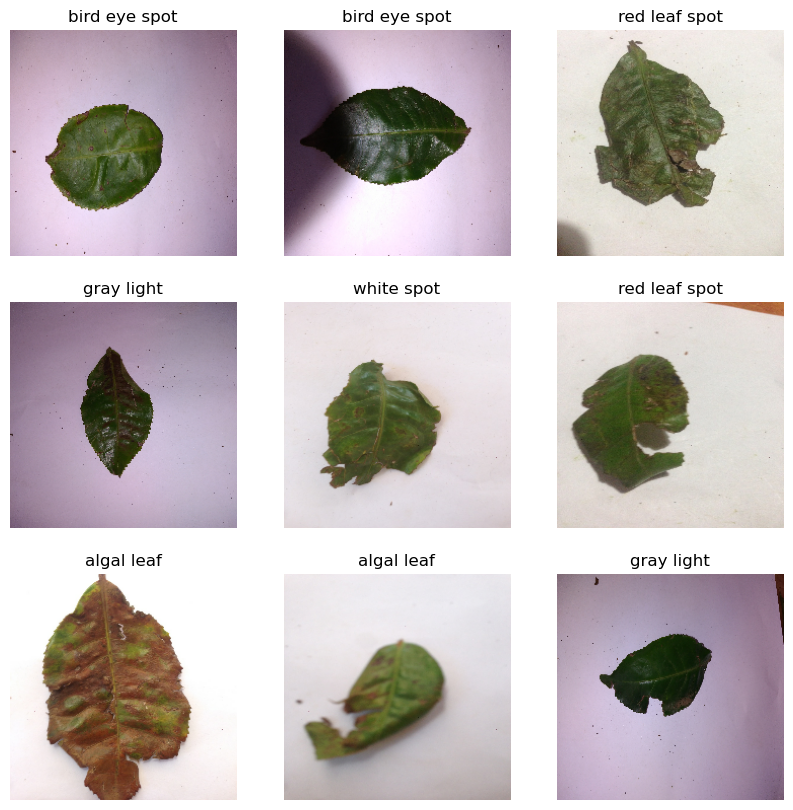

In [9]:
# Review 
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
# Data augmentation 
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal",input_shape=(img_height,img_width,3)),
    layers.RandomFlip("vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])

In [13]:
from tensorflow.keras.layers import LeakyReLU

# Model architecture
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same'),
    LeakyReLU(alpha=0.1),
    layers.MaxPooling2D(),
    layers.Conv2D(16, 3, padding='same'),
    LeakyReLU(alpha=0.1),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same'),
    LeakyReLU(alpha=0.1),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(32),
    LeakyReLU(alpha=0.1),
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    layers.Dense(32),
    LeakyReLU(alpha=0.1),
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    layers.Dense(num_classes)
])

In [14]:
# compiling model
base_learning_rate = 0.0005
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 224, 224, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 16)      2320      
                                                      

In [16]:
epochs=130
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    verbose=1
)

Epoch 1/130


5/5 [==============================] - 12s 1s/step - loss: 2.2589 - accuracy: 0.1927 - val_loss: 3.3746 - val_accuracy: 0.1592
Epoch 2/130
5/5 [==============================] - 5s 1s/step - loss: 2.1393 - accuracy: 0.2054 - val_loss: 3.1677 - val_accuracy: 0.1592
Epoch 3/130
5/5 [==============================] - 5s 1s/step - loss: 2.1044 - accuracy: 0.2389 - val_loss: 2.2471 - val_accuracy: 0.1592
Epoch 4/130
5/5 [==============================] - 5s 1s/step - loss: 1.9102 - accuracy: 0.3073 - val_loss: 1.8278 - val_accuracy: 0.1592
Epoch 5/130
5/5 [==============================] - 5s 1s/step - loss: 1.7259 - accuracy: 0.3280 - val_loss: 1.7858 - val_accuracy: 0.3376
Epoch 6/130
5/5 [==============================] - 5s 1s/step - loss: 1.6224 - accuracy: 0.3535 - val_loss: 1.6880 - val_accuracy: 0.4522
Epoch 7/130
5/5 [==============================] - 5s 997ms/step - loss: 1.4801 - accuracy: 0.4076 - val_loss: 1.6686 - val_accuracy: 0.3885
Epoch 8/130
5/5 [===========

Epoch 57/130
5/5 [==============================] - 5s 1s/step - loss: 0.4794 - accuracy: 0.8312 - val_loss: 0.6500 - val_accuracy: 0.8280
Epoch 58/130
5/5 [==============================] - 5s 1s/step - loss: 0.4675 - accuracy: 0.8328 - val_loss: 0.6322 - val_accuracy: 0.8535
Epoch 59/130
5/5 [==============================] - 5s 1s/step - loss: 0.4481 - accuracy: 0.8280 - val_loss: 0.5979 - val_accuracy: 0.8535
Epoch 60/130
5/5 [==============================] - 5s 1s/step - loss: 0.4557 - accuracy: 0.8264 - val_loss: 0.6374 - val_accuracy: 0.7962
Epoch 61/130
5/5 [==============================] - 6s 1s/step - loss: 0.4742 - accuracy: 0.8169 - val_loss: 0.6082 - val_accuracy: 0.8217
Epoch 62/130
5/5 [==============================] - 5s 1s/step - loss: 0.4813 - accuracy: 0.8264 - val_loss: 0.8078 - val_accuracy: 0.7070
Epoch 63/130
5/5 [==============================] - 5s 1s/step - loss: 0.4870 - accuracy: 0.8073 - val_loss: 0.6550 - val_accuracy: 0.8217
Epoch 64/130
5/5 [=========

Epoch 116/130
5/5 [==============================] - 5s 1s/step - loss: 0.3536 - accuracy: 0.8662 - val_loss: 0.4559 - val_accuracy: 0.7898
Epoch 117/130
5/5 [==============================] - 5s 1s/step - loss: 0.3375 - accuracy: 0.8726 - val_loss: 0.7529 - val_accuracy: 0.7325
Epoch 118/130
5/5 [==============================] - 5s 1s/step - loss: 0.3368 - accuracy: 0.8933 - val_loss: 0.6362 - val_accuracy: 0.7389
Epoch 119/130
5/5 [==============================] - 5s 1s/step - loss: 0.3020 - accuracy: 0.8949 - val_loss: 0.5026 - val_accuracy: 0.8025
Epoch 120/130
5/5 [==============================] - 5s 1s/step - loss: 0.2851 - accuracy: 0.8949 - val_loss: 0.4487 - val_accuracy: 0.7898
Epoch 121/130
5/5 [==============================] - 5s 1s/step - loss: 0.2899 - accuracy: 0.8885 - val_loss: 0.3623 - val_accuracy: 0.8599
Epoch 122/130
5/5 [==============================] - 5s 1s/step - loss: 0.2978 - accuracy: 0.9013 - val_loss: 0.3699 - val_accuracy: 0.8535
Epoch 123/130
5/5 [=

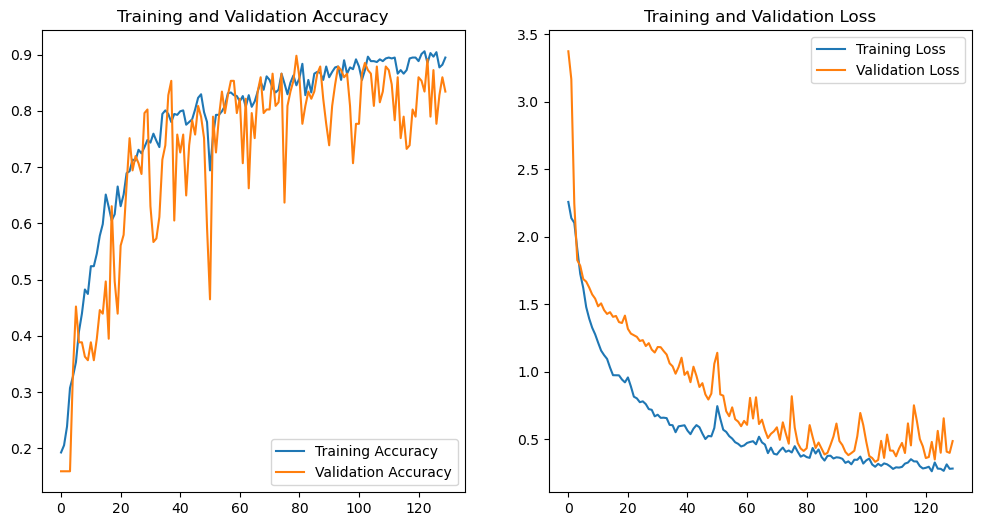

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

2/2 [==============================] - 0s 45ms/step


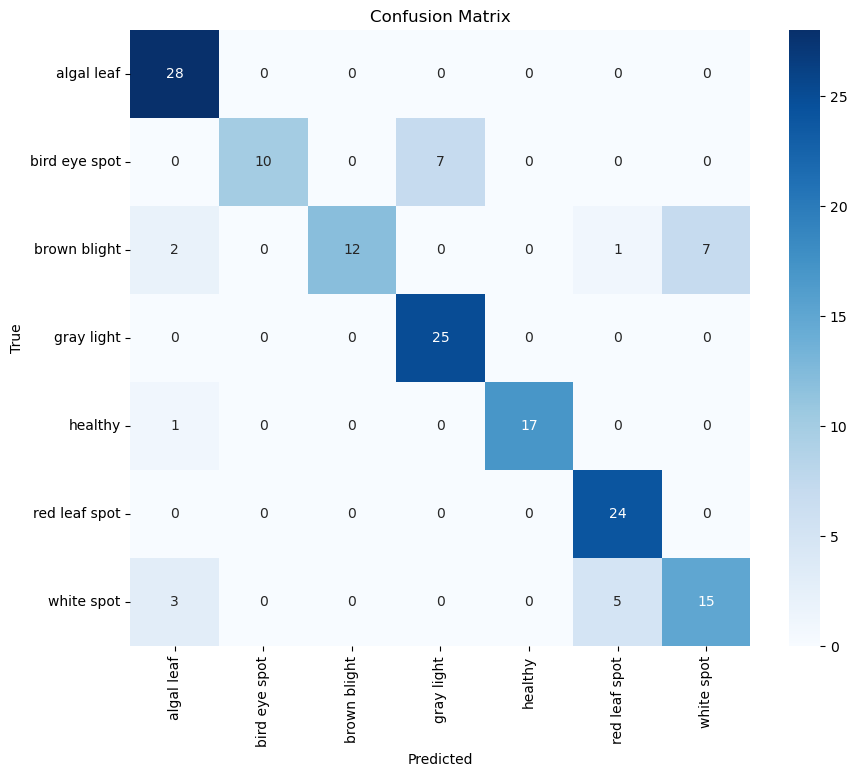

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


val_predictions = model.predict(val_ds)
val_predictions = np.argmax(val_predictions, axis=1)


true_labels = []
for _, labels in val_ds:
    true_labels.extend(labels.numpy())


conf_mat = confusion_matrix(true_labels, val_predictions)


plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Predictions:
 [4 0 3 6 6 5 0 1 5 6 1 6 5 5 3 3 1 5 3 5 3 6 0 0 0 3 0 6 1 5 3 4 6 4 2 5 0
 1 6 3 5 0 5 0 5 5 6 4 3 5 2 0 4 0 5 4 0 0 3 2 2 0 6 0 5 2 2 1 3 3 5 4 4 4
 3 0 0 2 6 5 6 4 5 3 2 0 6 6 2 3 3 0 1 3 6 6 5 3 0 3 5 0 5 4 3 0 5 4 5 5 4
 3 3 0 4 6 3 4 3 5 0 1 5 1 6 2 5 5]
Labels:
 [4 0 3 6 6 5 0 1 5 6 1 2 5 5 3 1 1 6 3 5 3 6 0 0 0 3 0 2 1 5 3 4 2 4 2 6 0
 1 2 1 5 2 2 0 5 6 6 4 3 6 2 0 4 6 5 4 0 0 3 2 2 0 2 6 6 2 2 1 3 3 5 4 4 4
 3 0 0 2 2 5 6 4 5 3 2 0 6 6 2 3 3 0 1 3 6 6 5 1 0 1 5 0 5 4 3 0 5 4 5 5 4
 3 3 0 4 6 3 4 1 5 0 1 5 1 6 2 5 5]

              precision    recall  f1-score   support

           0       0.88      1.00      0.93        21
           1       1.00      0.64      0.78        14
           2       1.00      0.56      0.71        18
           3       0.79      1.00      0.88        19
           4       1.00      1.00      1.00        15
           5       0.79      1.00      0.88        22
           6       0.67      0.63      0.65        19

    accuracy        

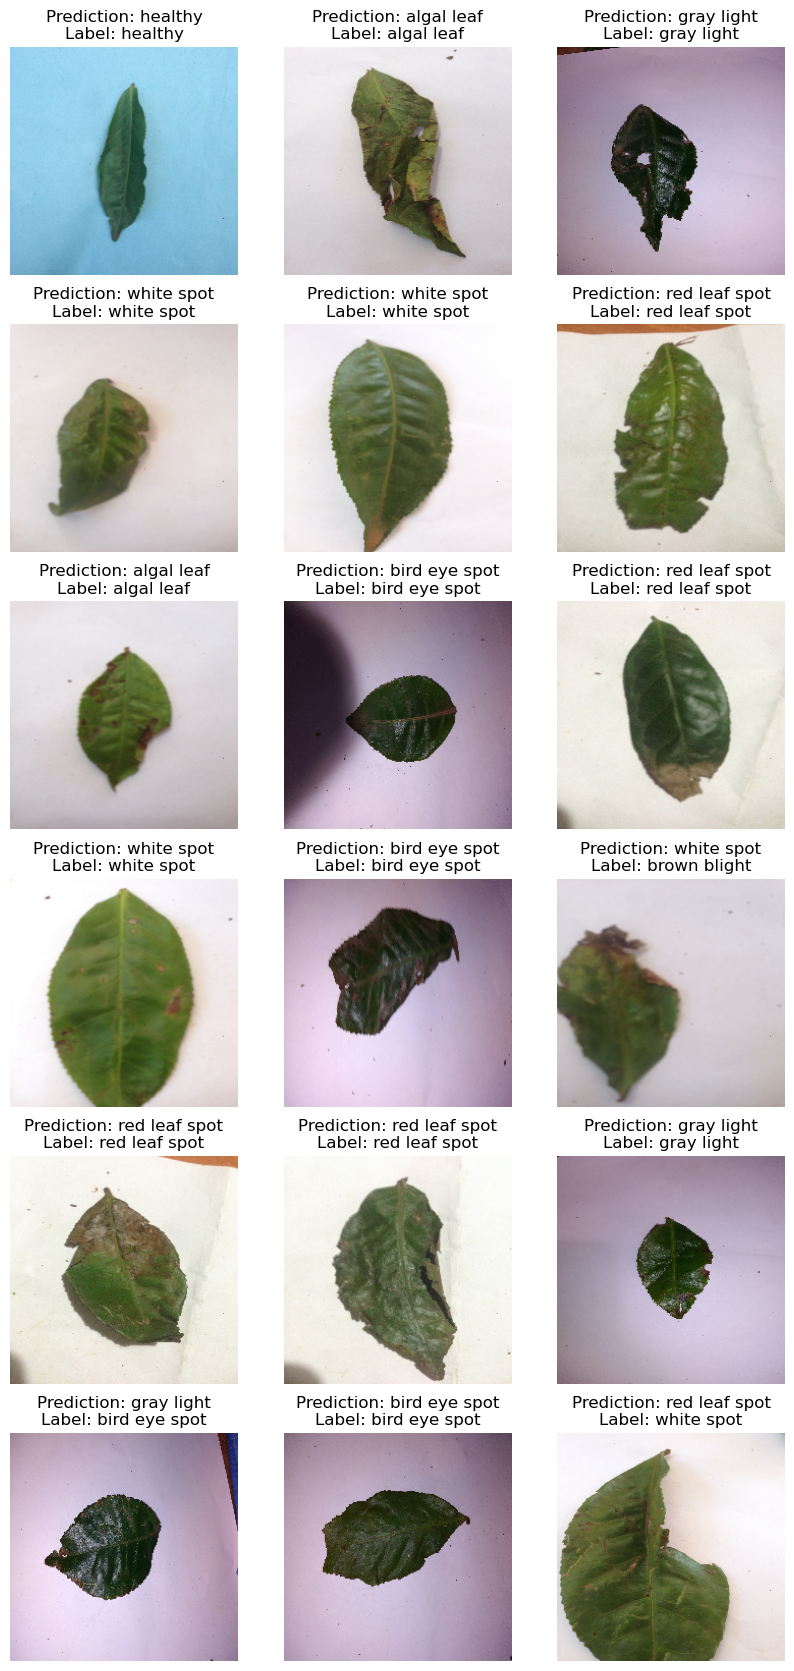

In [19]:

image_batch, label_batch = val_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

class_predictions = []
for i in predictions:
    class_prediction = np.argmax(i)
    class_predictions.append(class_prediction)

class_predictions = np.array(class_predictions)
print('Predictions:\n', class_predictions)
print('Labels:\n', label_batch)
print()
print(classification_report(label_batch, class_predictions))

plt.figure(figsize=(10, 21))
for i in range(18):
    ax = plt.subplot(6, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title("Prediction: "+class_names[class_predictions[i]]+"\nLabel: "+class_names[label_batch[i]])
    plt.axis("off")

In [ ]:
disease_info = {
    'algal leaf': {
        'Cure and Recovery': [
            "Remove affected leaves and destroy them.",
            "Apply a copper-based fungicide to control algal growth.",
            "Adjust irrigation practices to maintain optimal soil moisture."
        ]
    },
    'bird eye spot': {
        'Cure and Recovery': [
            "Prune affected branches to remove infected leaves.",
            "Use copper-based fungicides to control the spread.",
            "Apply organic fungicidal sprays for long-term management."
        ]
    },
    'brown blight': {
        'Cure and Recovery': [
            "Remove and destroy infected leaves promptly.",
            "Apply fungicides containing chlorothalonil.",
            "Adjust irrigation to minimize leaf wetness."
        ]
    },
    'gray light': {
        'Cure and Recovery': [
            "Prune affected branches and dispose of infected leaves.",
            "Use systemic fungicides for better control.",
            "Apply sulfur-based fungicides for organic management."
        ]
    },
    'healthy': {}, 
    'red leaf spot': {
        'Cure and Recovery': [
            "Remove and destroy infected leaves and debris.",
            "Apply fungicides containing mancozeb or copper.",
            "Improve drainage to prevent water stagnation."
        ]
    },
    'white spot': {
        'Cure and Recovery': [
            "Remove and destroy infected leaves promptly.",
            "Apply fungicides containing systemic action.",
            "Improve overall plant health with appropriate fertilization."
        ]
    }
}

In [ ]:
from tensorflow.keras.preprocessing import image


image_paths = [r"D:\Deep Learning project\testimg\w1.jpg",r"D:\Deep Learning project\testimg\w2.jpg",r"D:\Deep Learning project\testimg\w3.jpg", r"D:\Deep Learning project\testimg\w4.jpg", r"D:\Deep Learning project\testimg\w5.jpg", r"D:\Deep Learning project\testimg\a1.jpg",r"D:\Deep Learning project\testimg\a2.jpg",r"D:\Deep Learning project\testimg\a3.jpg", r"D:\Deep Learning project\testimg\a4.jpg", r"D:\Deep Learning project\testimg\a5.jpg", r"D:\Deep Learning project\testimg\b1.jpg",r"D:\Deep Learning project\testimg\b2.jpg",r"D:\Deep Learning project\testimg\b3.jpg", r"D:\Deep Learning project\testimg\b4.jpg", r"D:\Deep Learning project\testimg\b5.jpg", r"D:\Deep Learning project\testimg\g1.jpg",r"D:\Deep Learning project\testimg\g2.jpg",r"D:\Deep Learning project\testimg\g3.jpg", r"D:\Deep Learning project\testimg\g4.jpg", r"D:\Deep Learning project\testimg\g5.jpg", r"D:\Deep Learning project\testimg\h1.jpg",r"D:\Deep Learning project\testimg\h2.jpg",r"D:\Deep Learning project\testimg\h3.jpg", r"D:\Deep Learning project\testimg\h4.jpg", r"D:\Deep Learning project\testimg\h5.jpg", r"D:\Deep Learning project\testimg\r1.jpg",r"D:\Deep Learning project\testimg\r2.jpg",r"D:\Deep Learning project\testimg\r3.jpg", r"D:\Deep Learning project\testimg\r4.jpg", r"D:\Deep Learning project\testimg\r5.jpg"]


input_images = []
for img_path in image_paths:
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  
    input_images.append(img_array)

input_images = np.vstack(input_images)  


predictions = model.predict(input_images)


class_predictions = np.argmax(predictions, axis=1)


confidence_scores = np.max(tf.nn.softmax(predictions, axis=1), axis=1)


plt.figure(figsize=(15, len(image_paths) * 5))
for i in range(len(image_paths)):
    plt.subplot(len(image_paths)//2, 2, i + 1)
    plt.imshow(input_images[i].astype("uint8"))
    predicted_class = class_names[class_predictions[i]]
    cure_recovery_info = "\n".join(disease_info.get(predicted_class, {}).get('Cure and Recovery', ['Nothing to worry']))
    plt.title(f"Prediction: {predicted_class}, Confidence: {confidence_scores[i]:.4f}\n\nCure and Prevention:\n{cure_recovery_info}")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [20]:
model.save("D:\Deep Learning project/modelV2Best_augmentation")

INFO:tensorflow:Assets written to: D:\Deep Learning project/modelV2Best_augmentation\assets


INFO:tensorflow:Assets written to: D:\Deep Learning project/modelV2Best_augmentation\assets
